In [1]:
%load_ext watermark

In [2]:
%watermark -v --packages neupy,matplotlib,scikit-learn,numpy,scipy,sobol_seq,hyperopt

CPython 3.4.3
IPython 5.1.0

neupy 0.4.0
matplotlib 1.5.3
scikit-learn 0.18
numpy 1.11.2
scipy 0.18.1
sobol_seq 0.1.2
hyperopt 0.0.3.dev0


In [3]:
import warnings
import sklearn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

colors = plt.rcParams['axes.color_cycle']

In [4]:
import os

CURRENT_DIR = os.path.abspath(os.path.dirname(__name__))

def saveas(name):
    image_name = '{}.png'.format(name)
    image_path = os.path.join(CURRENT_DIR, '..', 'site', '2016',
                              '12', '17', 'images', image_name)
    plt.savefig(image_path, facecolor='#f8fafb', bbox_inches='tight')

## Random Search

In [5]:
# From: https://github.com/PhaethonPrime/hammersley/blob/master/hammersley/sequences.py

from six import moves, iteritems

# this list of primes allows up to a size 120 vector
saved_primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53,
59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137,
139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223,
227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307,
311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397,
401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487,
491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593,
599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659]

def get_phi(p, k):
    p_ = p
    k_ = k
    phi = 0
    while k_ > 0:
        a = k_ % p
        phi += a/p_
        k_ = int(k_/p)
        p_ *= p
    return phi

def generate_hammersley(n_dims=2, n_points=100, primes=None):
    primes = primes if primes is not None else saved_primes
    for k in moves.range(n_points):
        points = [k/n_points] + [get_phi(primes[d], k) for d in moves.range(n_dims-1)]
        yield points
        
def generate_halton(n_dims=2, n_points=100, primes=None):
    primes = primes if primes is not None else saved_primes
    for k in moves.range(n_points):
        points = [get_phi(primes[d], k) for d in moves.range(n_dims)]
        yield points

In [6]:
import sobol_seq

uniform_points = np.random.random((100, 2))
sobol_points = np.array(sobol_seq.i4_sobol_generate(2, 100))
hammersley_points = np.array(list(generate_hammersley()))
halton_points = np.array(list(generate_halton()))

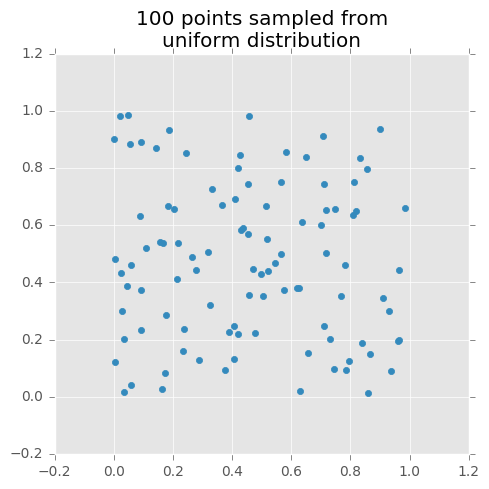

In [7]:
fig = plt.figure(figsize=(5, 5))

plt.title("100 points sampled from\nuniform distribution")
plt.scatter(*uniform_points.T, color=colors[1])

fig.tight_layout()
saveas('100-uniform-data-points')

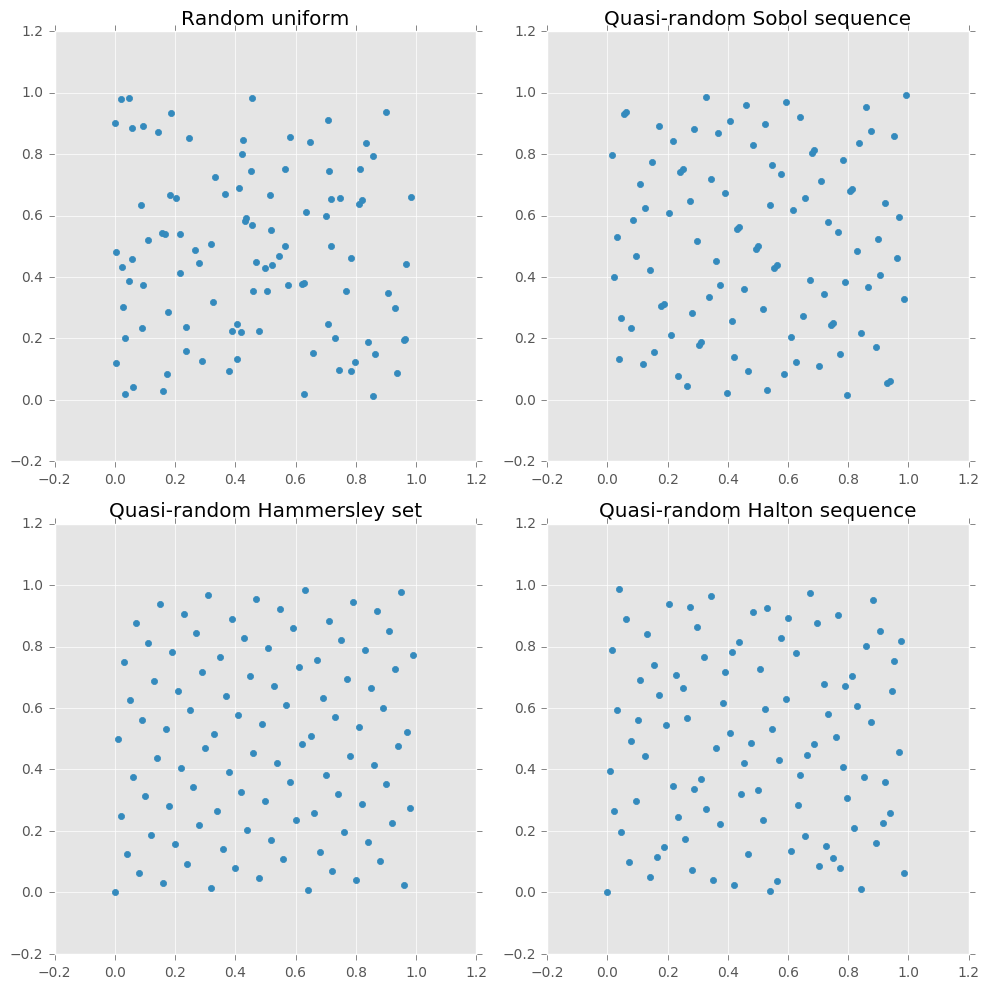

In [8]:
fig = plt.figure(figsize=(10, 10))

def plot_points(grid, position, points, title=""):
    ax = plt.subplot2grid(grid, position)
    
    ax.set_title(title)
    ax.scatter(*points.T, color=colors[1])

plot_points((2, 2), (0, 0), uniform_points,
            title="Random uniform")
plot_points((2, 2), (0, 1), sobol_points,
            title="Quasi-random Sobol sequence")
plot_points((2, 2), (1, 0), hammersley_points,
            title="Quasi-random Hammersley set")
plot_points((2, 2), (1, 1), halton_points,
            title="Quasi-random Halton sequence")

fig.tight_layout()
saveas('100-random-points')

## Human Expert Optimization

In [9]:
x = np.array([10, 100, 200])
y = np.array([65, 82, 84])

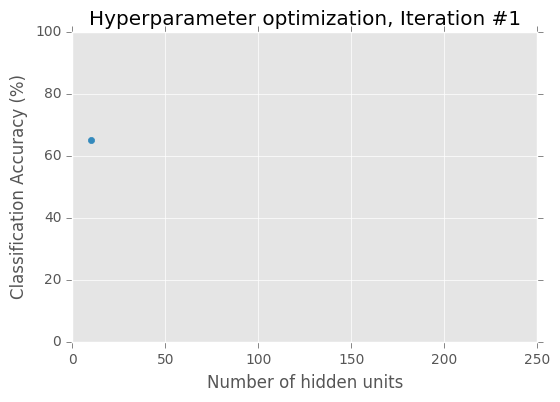

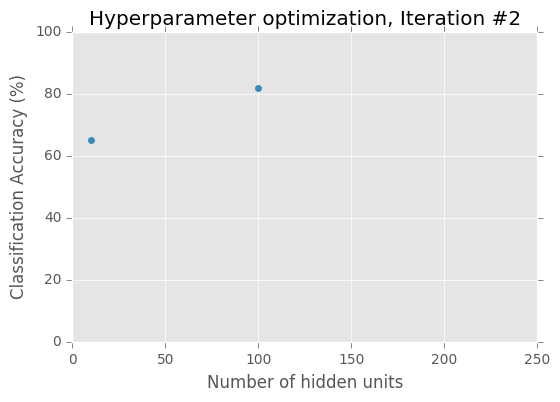

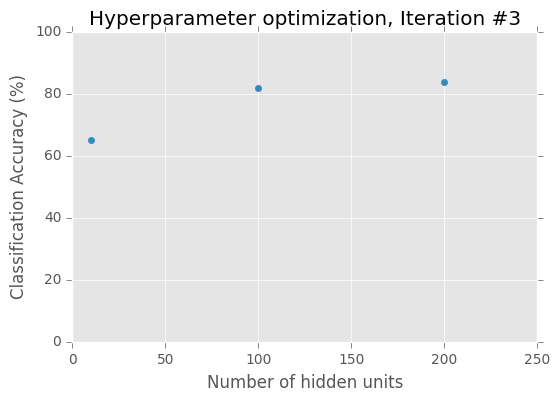

In [10]:
for i in range(1, 4):
    plt.scatter(x[:i], y[:i], color=colors[1])

    plt.title("Hyperparameter optimization, Iteration #{}".format(i))
    plt.xlabel("Number of hidden units")
    plt.ylabel("Classification Accuracy (%)")

    plt.ylim(0, 100)
    plt.xlim(0, 250)
    
    saveas('hid-units-vs-accuracy-iter{}'.format(i))
    plt.show()

## Gaussian Process

In [11]:
from sklearn.gaussian_process import GaussianProcess, GaussianProcessRegressor
from sklearn.gaussian_process import correlation_models as correlation

def plot_gp_bounds(x, y, x_predict, y_predict, y_std, ax=None):
    if ax is None:
        ax = plt.gca()
        
    bound1 = y_predict + 1.96 * y_std
    bound2 = y_predict - 1.96 * y_std

    ax.plot(x_predict, y_predict, color=colors[1])
    ax.plot(x_predict, bound1, color=colors[1])
    ax.plot(x_predict, bound2, color=colors[1])
    
    ax.fill_between(
        x_predict,
        bound1.reshape(len(bound1)),
        bound2.reshape(len(bound2)),
        alpha=0.3
    )
    ax.scatter(x, y, color=colors[1], s=50)
    
    return ax

def gp(x, y, index, nugget=1e-5):
    gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                         thetaL=1e-3, thetaU=1, nugget=nugget)
    
    xi = x[:index].reshape((-1, 1))
    yi = y[:index].reshape((-1, 1))
    gp.fit(xi, yi)

    x_predict = np.linspace(0, 200, 1000)
    y_predict, y_var = gp.predict(np.atleast_2d(x_predict).T, eval_MSE=True)
    y_std = np.sqrt(y_var.reshape((-1, 1)))

    return xi, yi, x_predict, y_predict, y_std

def plot_gp_example1(xi, yi, x_predict, y_predict, y_std, index, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.set_title("Gaussian Process regression after {} iterations".format(index))
    ax.set_xlabel("Number of hidden units")
    ax.set_ylabel("Classification Accuracy (%)")

    plot_gp_bounds(xi, yi, x_predict, y_predict, y_std, ax=ax)

    ax.set_ylim(50, 100)
    ax.set_xlim(0, 200)
    
    return ax

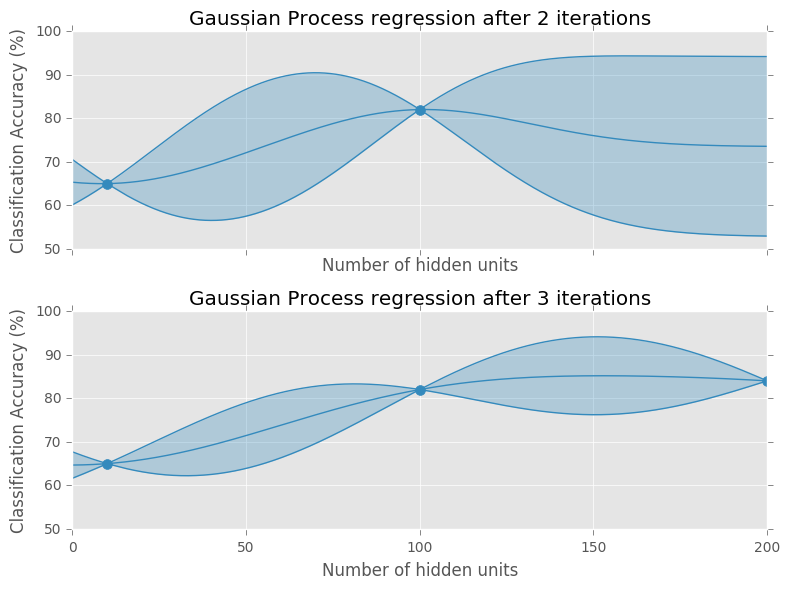

In [12]:
fig, axes = plt.subplots(2, figsize=(8, 6), sharex=True)
for index, ax in enumerate(axes, start=2):
    xi, yi, x_predict, y_predict, y_std = gp(x, y, index)
    plot_gp_example1(xi, yi, x_predict, y_predict, y_std, index, ax)
    
fig.tight_layout()
saveas('gaussian-process-example')

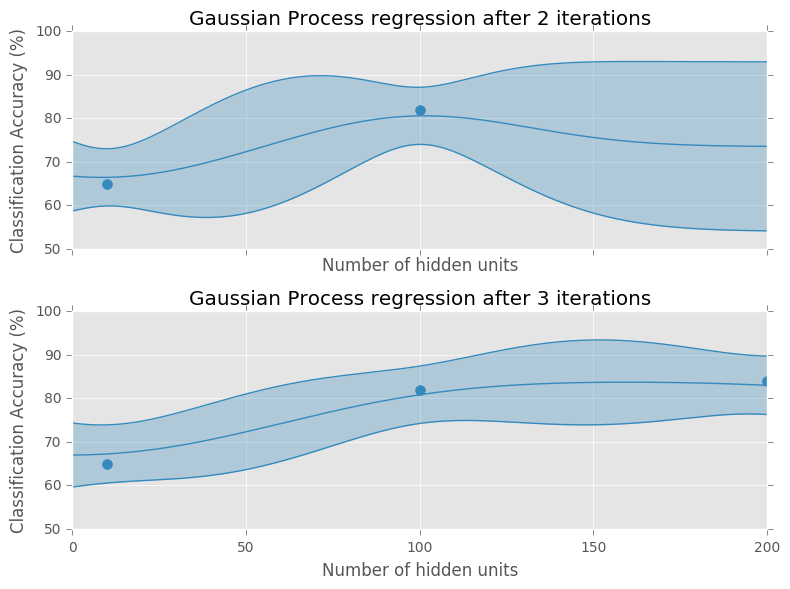

In [13]:
fig, axes = plt.subplots(2, figsize=(8, 6), sharex=True)
for index, ax in enumerate(axes, start=2):
    xi, yi, x_predict, y_predict, y_std = gp(x, y, index, nugget=0.2)
    plot_gp_example1(xi, yi, x_predict, y_predict, y_std, index, ax)
    
fig.tight_layout()
saveas('gaussian-process-noise-example')

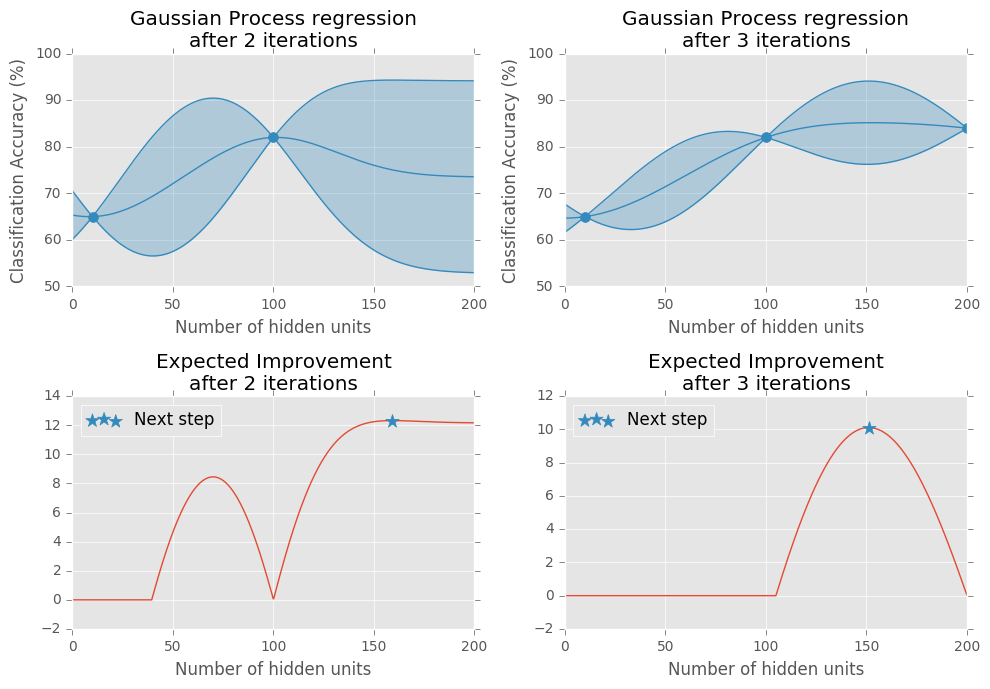

In [14]:
fig = plt.figure(figsize=(10, 7))

for column_id, index in enumerate([2, 3]):
    ax1 = plt.subplot2grid((2, 2), (0, column_id))
    ax2 = plt.subplot2grid((2, 2), (1, column_id), sharex=ax1)

    xi, yi, x_predict, y_predict, y_std = gp(x, y, index)
    ax1 = plot_gp_example1(xi, yi, x_predict, y_predict, y_std, index, ax1)
    ax1.set_title("Gaussian Process regression\nafter {} iterations".format(index))

    y_max = max(yi)
    expected_improvement = (y_predict + 1.96 * y_std) - y_max
    expected_improvement[expected_improvement < 0] = 0

    ax2.set_title("Expected Improvement\nafter {} iterations".format(index))
    ax2.set_xlabel('Number of hidden units')
    ax2.plot(x_predict, expected_improvement)
    
    max_index = expected_improvement.argmax()
    ax2.scatter(x_predict[max_index], expected_improvement[max_index],
                marker='*', s=100, color=colors[1],
                label='Next step', zorder=10)

    ax2.legend(loc='upper left')

fig.tight_layout()
saveas('expected-improvement-example')

## Multivariate Gaussian Example

In [15]:
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

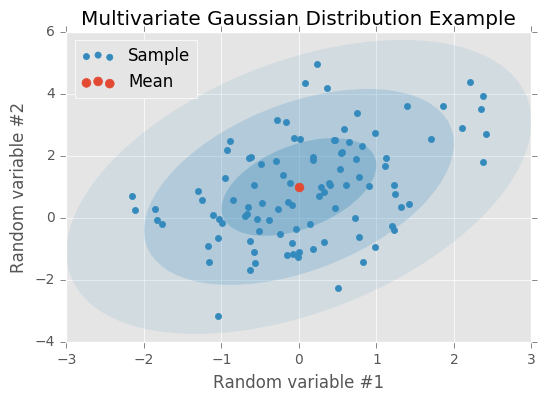

In [16]:
from scipy.stats import multivariate_normal

mean = np.array([0, 1])
covariance = np.array([
    [1, 0.7],
    [0.7, 2.5],
])

np.random.seed(0)
mv_normal = multivariate_normal(mean, covariance)
nv_normal_samples = mv_normal.rvs(100)

plot_cov_ellipse(covariance, mean, nstd=1, alpha=0.3)
plot_cov_ellipse(covariance, mean, nstd=2, alpha=0.2)
plot_cov_ellipse(covariance, mean, nstd=3, alpha=0.1)

plot_blue_samples = plt.scatter(*nv_normal_samples.T, color=colors[1],
                                alpha=1, zorder=10, label='Sample')
plot_mean = plt.scatter(*mean, color=colors[0], s=40, alpha=1,
                        zorder=10, label='Mean')

plt.legend(handles=[plot_blue_samples, plot_mean], loc=2)
plt.title("Multivariate Gaussian Distribution Example")
plt.xlabel("Random variable #1")
plt.ylabel("Random variable #2")

saveas('mulvar-gauss-dist-example')

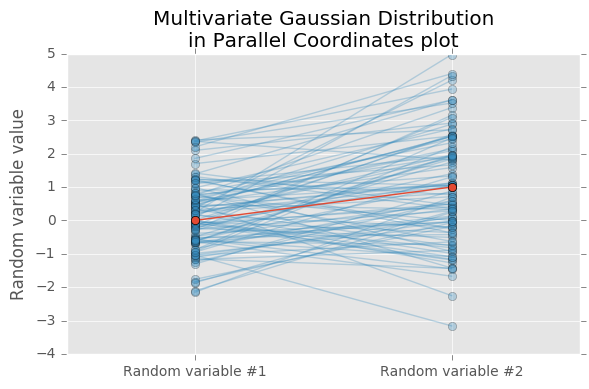

In [17]:
fig = plt.figure()

for sample in nv_normal_samples:
    plt.plot([0, 1], sample, 'o-', color=colors[1], alpha=0.3)
    
plt.plot([0, 1], mean, 'o-', color=colors[0], alpha=1)

plt.title("Multivariate Gaussian Distribution\nin Parallel Coordinates plot")
plt.ylabel("Random variable value")
plt.xticks([0, 1], ['Random variable #1', 'Random variable #2'])
plt.xlim(-0.5, 1.5)

fig.tight_layout()
saveas('mulvar-gauss-dist-parallel-coords')

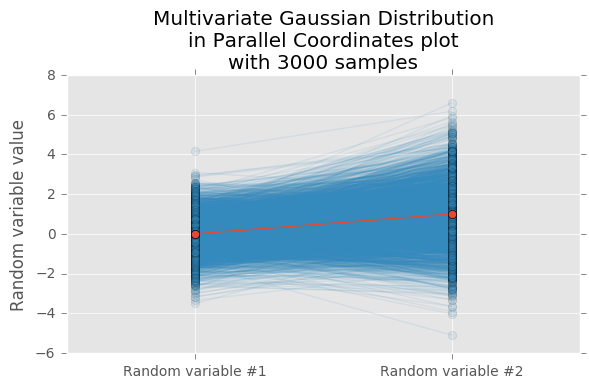

In [18]:
n_samples = 3000
np.random.seed(0)
nv_normal_many_samples = mv_normal.rvs(n_samples)
fig = plt.figure()

for sample in nv_normal_many_samples:
    plt.plot([0, 1], sample, 'o-', color=colors[1], alpha=0.1)
    
plt.plot([0, 1], mean, 'o-', color=colors[0], alpha=1)

plt.title("Multivariate Gaussian Distribution\n"
          "in Parallel Coordinates plot\n"
          "with {} samples".format(n_samples))
plt.ylabel("Random variable value")
plt.xticks([0, 1], ['Random variable #1', 'Random variable #2'])
plt.xlim(-0.5, 1.5)

fig.tight_layout()
saveas('mulvar-gauss-dist-parallel-coords-many-samples')

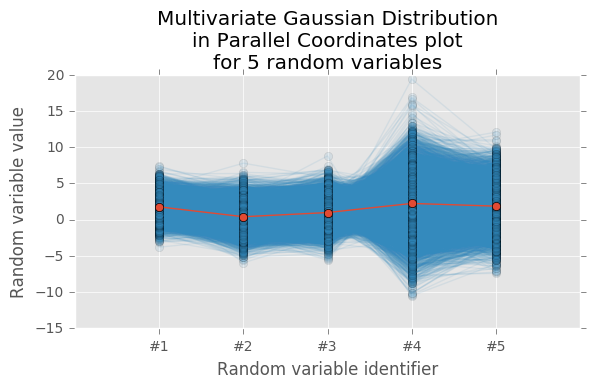

In [19]:
def random_cov(n):
    random_matrix = np.random.randn(n, n)
    pos_semidef = np.dot(random_matrix, random_matrix.T)
    return pos_semidef

np.random.seed(0)

ndim = 5
variables = np.arange(ndim)
mean = np.random.randn(ndim)
covariance = random_cov(ndim)
mv_normal = multivariate_normal(mean, covariance)

n_samples = 10000
nv_normal_samples = mv_normal.rvs(n_samples)

fig = plt.figure()

for sample in nv_normal_samples:
    plt.plot(variables, sample, 'o-', color=colors[1], alpha=0.1)

plt.plot(variables, mean, 'o-', color=colors[0], alpha=1)

plt.title("Multivariate Gaussian Distribution\n"
          "in Parallel Coordinates plot\n"
          "for {} random variables".format(ndim))
plt.ylabel("Random variable value")
plt.xlabel("Random variable identifier")
plt.xlim(-1, ndim)

variable_names = ['#{}'.format(variable + 1) for variable in variables]
plt.xticks(variables, variable_names)

fig.tight_layout()
saveas('mulvar-gauss-dist-parallel-coords-5d')

## Number of hidden units for 8x8 digit images

Couldn't import dot_parser, loading of dot files will not be possible.
-----------------------
Iteration #1
Number of hidden layers: 914
Cross entropy score: 0.09049941957147169
-----------------------
Iteration #2
Number of hidden layers: 444
Cross entropy score: 0.13807060486135683
-----------------------
Iteration #3
Number of hidden layers: 50
Cross entropy score: 0.1877074118439599
-----------------------
Iteration #4
Number of hidden layers: 1000
Cross entropy score: 0.12063562672549547
-----------------------
Iteration #5
Number of hidden layers: 711
Cross entropy score: 0.1010262723705697
-----------------------
Iteration #6
Number of hidden layers: 830
Cross entropy score: 0.10913144311367153

Best number of hidden units: 914


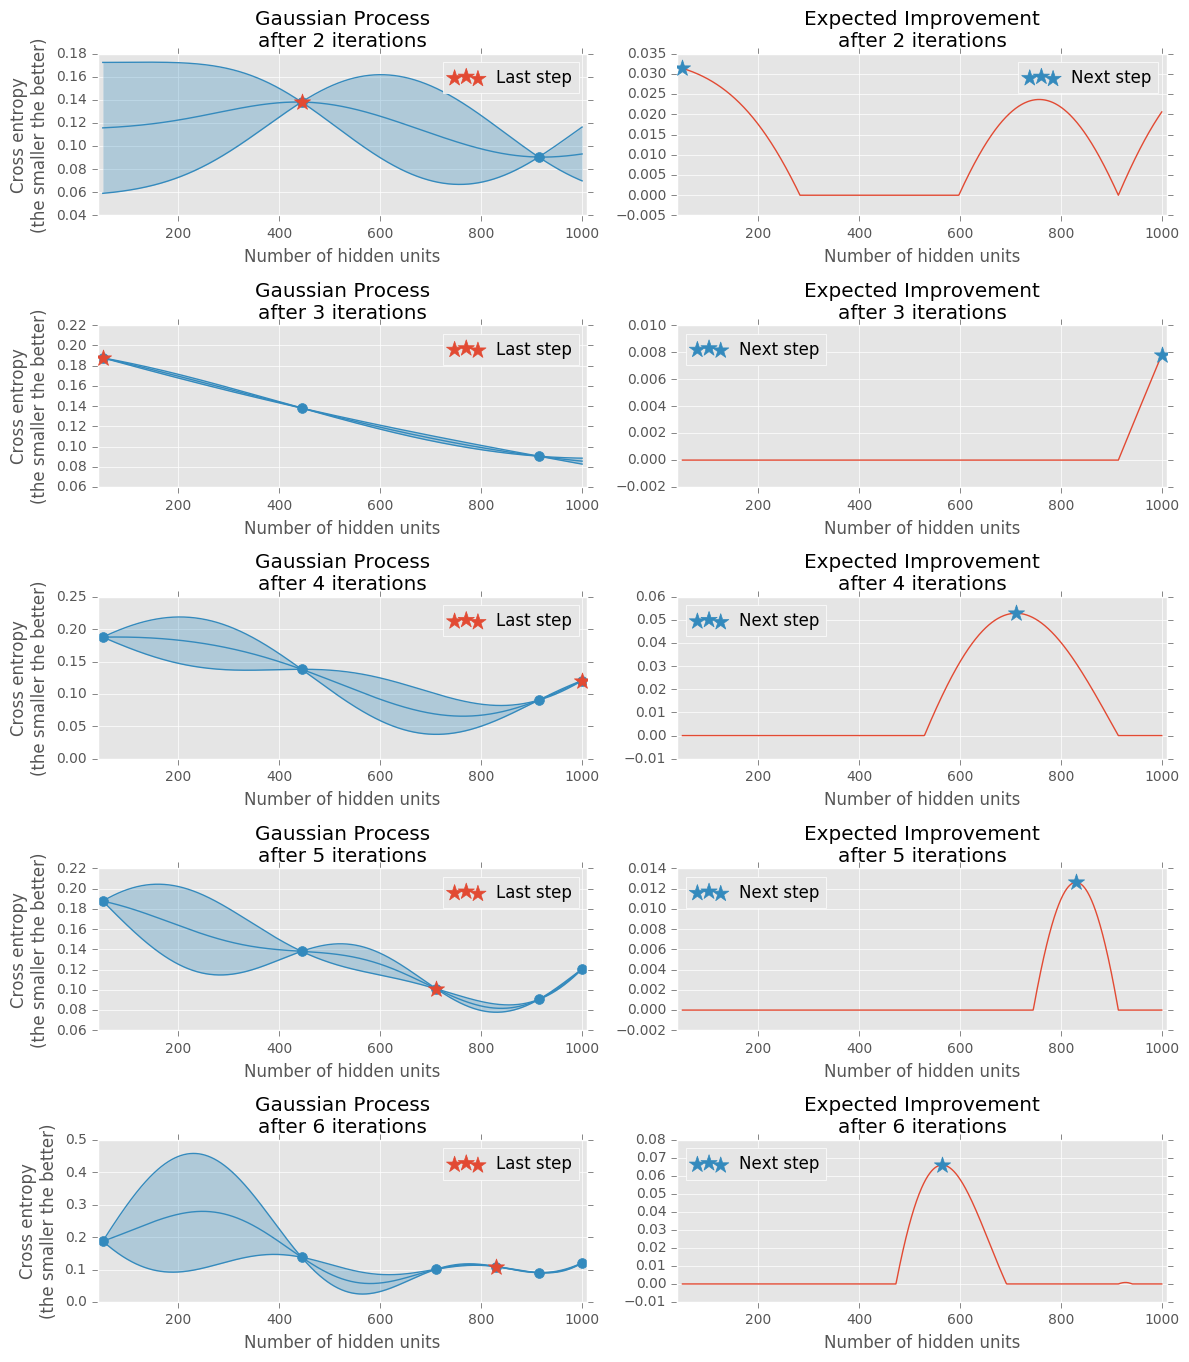

In [20]:
import random
from sklearn import datasets, model_selection
from neupy import algorithms, layers, environment, estimators
from sklearn.gaussian_process import kernels

def vector_2d(array):
    return np.array(array).reshape((-1, 1))
    
def hyperparam_selection(func, n_hidden_range, func_args=None, n_iter=20):
    if func_args is None:
        func_args = []

    scores = []
    parameters = []

    min_n_hidden, max_n_hidden = n_hidden_range
    n_hidden_choices = np.arange(min_n_hidden, max_n_hidden + 1)
    
    for iteration in range(1, n_iter + 1):
        if iteration in (1, 2):
            n_hidden = random.randint(min_n_hidden, max_n_hidden)

        print('-----------------------')
        print('Iteration #{}'.format(iteration))
        print("Number of hidden layers: {}".format(n_hidden))

        nnet, score = func(n_hidden, *func_args)

        print("Cross entropy score: {}".format(score))

        parameters.append(n_hidden)
        scores.append(score)

        # To be able to perfome gaussian process we need to
        # have at least 2 samples.
        if iteration < 2:
            continue

        x_train = vector_2d(parameters)
        y_train = vector_2d(scores)
        x_test = vector_2d(n_hidden_choices)

        # Train gaussian process
        gp = GaussianProcess(corr='squared_exponential',
                             theta0=1e-1, thetaL=1e-3, thetaU=1)
        gp.fit(x_train, y_train)

        # Get mean and standard deviation for each possible
        # number of hidden units
        y_mean, y_var = gp.predict(x_test, eval_MSE=True)
        y_std = np.sqrt(vector_2d(y_var))

        y_min = min(scores)

        # Calculate expecte improvement from 95% confidence interval
        expected_improvement = y_min - (y_mean - 1.96 * y_std)
        expected_improvement[expected_improvement < 0] = 0

        max_index = expected_improvement.argmax()
        # Select next choice based on expected improvement
        n_hidden = n_hidden_choices[max_index]
        
        # Build plots
        ax1 = plt.subplot2grid((n_iter, 2), (iteration - 1, 0))
        ax2 = plt.subplot2grid((n_iter, 2), (iteration - 1, 1))
        
        order = np.argsort(parameters)

        plot_gp_bounds(x_train, y_train, n_hidden_choices, y_mean, y_std, ax1)
        ax1.scatter(parameters[-1], scores[-1], marker='*', s=150,
                    color=colors[0], zorder=10, label='Last step')
        ax1.set_title("Gaussian Process\nafter {} iterations".format(iteration))
        ax1.set_xlim(min_n_hidden - 10, max_n_hidden + 10)
        ax1.set_xlabel("Number of hidden units")
        ax1.set_ylabel("Cross entropy\n(the smaller the better)")
        ax1.legend(loc='upper right')
        
        ax2.plot(n_hidden_choices, expected_improvement)
        ax2.scatter(n_hidden_choices[max_index], expected_improvement[max_index],
                    marker='*', s=150, color=colors[1], label='Next step', zorder=10)
        ax2.set_xlim(min_n_hidden - 10, max_n_hidden + 10)
        ax2.set_title("Expected Improvement\nafter {} iterations".format(iteration))
        ax2.set_xlabel("Number of hidden units")
        
        if n_hidden > 450:
            ax2.legend(loc='upper left')
        else:
            ax2.legend(loc='upper right')
        
        if y_min == 0 or n_hidden in parameters:
            print("Converged")
            break
            
    min_score_index = np.argmin(scores)
    return parameters[min_score_index]
    
def train_network(n_hidden, x_train, x_test, y_train, y_test):
    network = algorithms.Momentum(
        [
            layers.Input(64),
            layers.Relu(n_hidden),
            layers.Softmax(10),
        ],

        # Randomly shuffle dataset before each
        # training epoch.
        shuffle_data=True,
        
        # Do not show training progress in output
        verbose=False,

        step=0.001,
        batch_size=128,
        error='categorical_crossentropy',
    )
    network.train(x_train, y_train, x_test, y_test, epochs=100)

    # Calculates categorical cross-entropy error between
    # predicted value for x_test and y_test value
    return network, network.score(x_test, y_test)


environment.reproducible()
    
dataset = datasets.load_digits()
n_samples = dataset.target.size
n_classes = 10
target = np.zeros((n_samples, n_classes))
target[np.arange(n_samples), dataset.target] = 1

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    dataset.data, target, train_size=0.9
)

fig = plt.figure(figsize=(12, 16))
best_n_hidden = hyperparam_selection(
    train_network,
    n_hidden_range=[50, 1000],
    func_args=[x_train, x_test, y_train, y_test],
    n_iter=6,
)

print("")
print("Best number of hidden units: {}".format(best_n_hidden))

plt.tight_layout()
saveas('hyperparam-selection-nn-hidden-units')

## Tree-structured Parzen Estimators

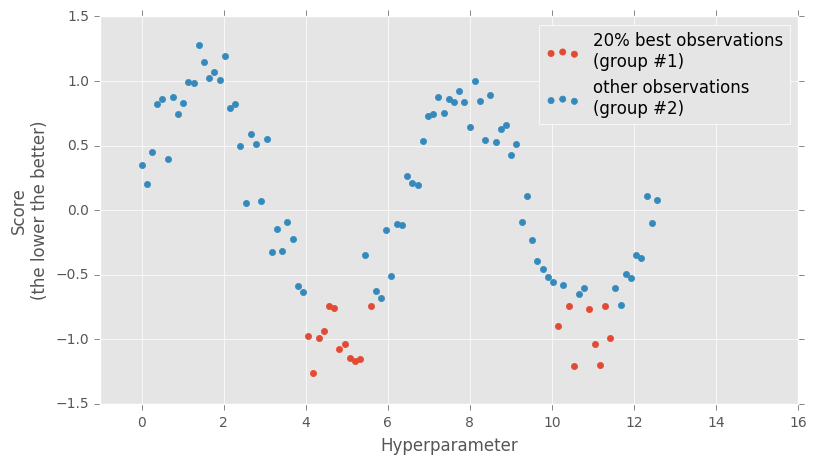

In [21]:
import random

def f(x):
    return np.sin(x) + 0.2 * np.random.randn(*x.shape)

np.random.seed(0)

x = np.linspace(0, 4 * np.pi, 100)
y = f(x)

best_ratio = 0.2
n_best = int(len(x) * best_ratio)

y_sorted_index = np.argsort(y)
y_sorted = y[y_sorted_index]
x_sorted = x[y_sorted_index]

x_best = x_sorted[:n_best]
y_best = y_sorted[:n_best]

x_worst = x_sorted[n_best:]
y_worst = y_sorted[n_best:]

plt.figure(figsize=(9, 5))
plt.scatter(x_best, y_best, color=colors[0],
            label="20% best observations\n(group #1)")
plt.scatter(x_worst, y_worst, color=colors[1],
            label="other observations\n(group #2)")
plt.legend(loc='upper right')

plt.ylabel("Score\n(the lower the better)")
plt.xlabel("Hyperparameter")
plt.xlim(-1, 16)

saveas('tpe-observation-groups')

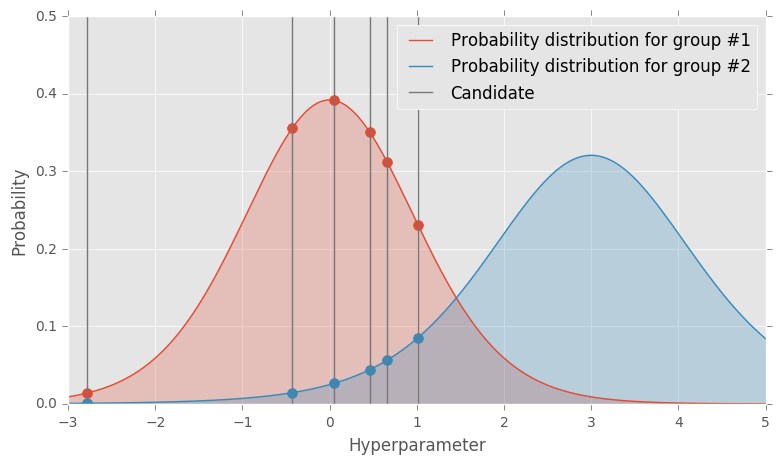

In [22]:
from scipy import stats

np.random.seed(2)

best_proba = stats.t(15, 0, 1)
worst_proba = stats.t(7, 3, 1.2)

x = np.linspace(-3, 5, 1000)
y_best = best_proba.pdf(x)
y_worst = worst_proba.pdf(x)

plt.figure(figsize=(9, 5))

best_proba_line, = plt.plot(x, y_best, color=colors[0])
plt.fill_between(x, 0, y_best, color=colors[0], alpha=0.25)

worst_proba_line, = plt.plot(x, y_worst, color=colors[1], label='g(x)')
plt.fill_between(x, 0, y_worst, color=colors[1], alpha=0.25)

x_candidates = best_proba.rvs(6)
for x_candidate in x_candidates:
    candidate_line = plt.axvline(x_candidate, 0, 1,
                                 color=colors[3])
    plt.scatter(x_candidate, best_proba.pdf(x_candidate),
                s=50, color=colors[0])
    plt.scatter(x_candidate, worst_proba.pdf(x_candidate),
                s=50, color=colors[1])

plt.ylabel("Probability")
plt.xlabel("Hyperparameter")
plt.xlim(-3, 5)
plt.ylim(0, 0.5)

plt.legend([
        best_proba_line,
        worst_proba_line,
        candidate_line,
    ], [
        'Probability distribution for group #1',
        'Probability distribution for group #2',
        'Candidate',
    ],
    loc='upper right'
)
saveas('tpe-sampled-candidates')

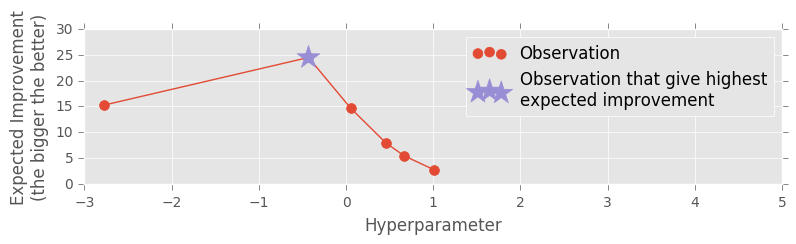

In [23]:
x_candidates.sort()
expected_improvement = best_proba.pdf(x_candidates) / worst_proba.pdf(x_candidates)
max_index = expected_improvement.argmax()

plt.figure(figsize=(9, 2))
plt.plot(x_candidates, expected_improvement)
plt.scatter(x_candidates, expected_improvement, color=colors[0], s=50,
            label='Observation')
plt.scatter(x_candidates[max_index], expected_improvement[max_index],
            marker='*', s=300, color=colors[2], zorder=10,
            label='Observation that give highest\nexpected improvement')
plt.ylabel("Expected Improvement\n(the bigger the better)")
plt.xlabel("Hyperparameter")
plt.xlim(-3, 5)
plt.legend(loc='upper right')

saveas('tpe-expected-improvement')

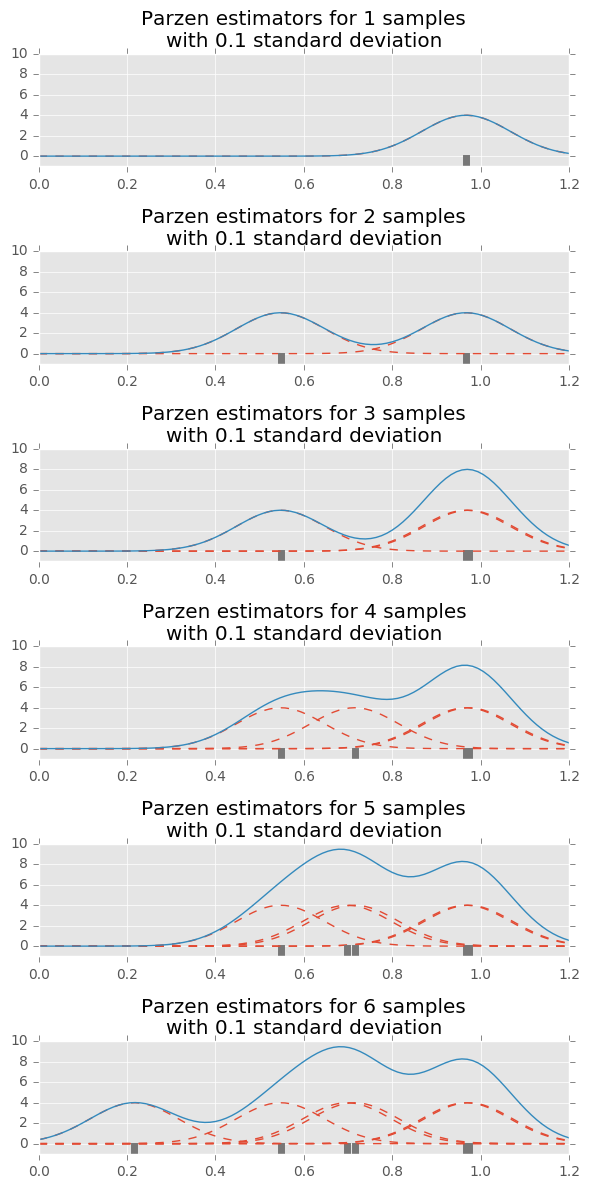

In [24]:
from scipy import stats

fig = plt.figure(figsize=(6, 12))
for i in range(1, 7):
    np.random.seed(4)
    samples = np.random.random(i)
    
    ax = plt.subplot2grid((6, 1), (i - 1, 0))

    x = np.linspace(0, 1.2, 100)
    y_total = np.zeros(x.shape)
    for sample in samples:
        dist = stats.norm(sample, 0.1)
        y = dist.pdf(x)
        y = y
        y_total += y

        ax.plot(x, y, '--', color=colors[0])
        ax.plot([sample, sample], [-1, -0.2], color=colors[3], linewidth=5)

    ax.set_title("Parzen estimators for {} samples\n"
                 "with 0.1 standard deviation".format(i))
    ax.plot(x, y_total, color=colors[1])
#     ylim_lower, ylim_upper = ax.get_ylim()
    ax.set_ylim(-1, 10)

fig.tight_layout()
saveas('parzen-estimators')

In [25]:
from pprint import pprint
from functools import partial

import theano
import numpy as np
from sklearn import model_selection, datasets, preprocessing, metrics
import hyperopt
from hyperopt import hp
from neupy import algorithms, layers, environment
from neupy.exceptions import StopTraining

theano.config.floatX = 'float32'

def on_epoch_end(network):
    if network.training_errors[-1] > 10:
        raise StopTraining("Training was interrupted. Error is to high.")

def train_network(parameters):
    print("Parameters:")
    pprint(parameters)
    print()

    step = parameters['step']
    batch_size = int(parameters['batch_size'])
    proba = parameters['dropout']
    activation_layer = parameters['act_func_type']
    layer_sizes = [int(n) for n in parameters['layers']['n_units_layer']]
    
    network = layers.Input(784)

    for layer_size in layer_sizes:
        network = network > activation_layer(layer_size)

    network = network > layers.Dropout(proba) > layers.Softmax(10)
    
    mnet = algorithms.RMSProp(
        network,

        batch_size=batch_size,
        step=step,
        
        error='categorical_crossentropy',
        shuffle_data=True,
        
        epoch_end_signal=on_epoch_end,
    )
    mnet.train(x_train, y_train, epochs=50)
    
    score = mnet.score(x_test, y_test)
    
    y_predicted = mnet.predict(x_test).argmax(axis=1)
    accuracy = metrics.accuracy_score(y_test.argmax(axis=1), y_predicted)
    
    print("Final score: {}".format(score))
    print("Accuracy: {:.2%}".format(accuracy))

    return score

In [26]:
def uniform_int(name, lower, upper):
    # `quniform` returns:
    # round(uniform(low, high) / q) * q
    return hp.quniform(name, lower, upper, q=1)

def loguniform_int(name, lower, upper):
    # Do not forget to make a logarithm for the
    # lower and upper bounds.
    return hp.qloguniform(name, np.log(lower), np.log(upper), q=1)

In [27]:
def load_mnist_dataset():
    mnist = datasets.fetch_mldata('MNIST original')

    target_scaler = preprocessing.OneHotEncoder()
    target = mnist.target.reshape((-1, 1))
    target = target_scaler.fit_transform(target).todense()

    data = mnist.data / 255.
    data = data - data.mean(axis=0)

    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        data.astype(np.float32),
        target.astype(np.float32),
        test_size=(1 / 7.)
    )
    
    return x_train, x_test, y_train, y_test

environment.reproducible()
x_train, x_test, y_train, y_test = load_mnist_dataset()

In [28]:
# Object stores all information about each trial.
# Also, it stores information about the best trial.
trials = hyperopt.Trials()

parameter_space = {
    'step': hp.uniform('step', 0.01, 0.5),
    'layers': hp.choice('layers', [{
        'n_layers': 1,
        'n_units_layer': [
            uniform_int('n_units_layer_11', 50, 500),
        ],
    }, {
        'n_layers': 2,
        'n_units_layer': [
            uniform_int('n_units_layer_21', 50, 500),
            uniform_int('n_units_layer_22', 50, 500),
        ],
    }]),
    'act_func_type': hp.choice('act_func_type', [
        layers.Relu,
        layers.PRelu,
        layers.Elu,
        layers.Tanh,
        layers.Sigmoid
    ]),
    
    'dropout': hp.uniform('dropout', 0, 0.5),
    'batch_size': loguniform_int('batch_size', 16, 512),
}

In [29]:
tpe = partial(
    hyperopt.tpe.suggest,

    # Sample 1000 candidate and select candidate that
    # has highest Expected Improvement (EI)
    n_EI_candidates=1000,
    
    # Use 20% of best observations to estimate next
    # set of parameters
    gamma=0.2,
    
    # First 20 trials are going to be random
    n_startup_jobs=20,
)

hyperopt.fmin(
    train_network,
    trials=trials,
    space=parameter_space,

    # Set up TPE for hyperparameter optimization
    algo=tpe,

    # Maximum number of iterations. Basically it trains at
    # most 200 networks before choose the best one.
    max_evals=200,
)